In [1]:
!pip -q install monai
!pip -q install segmentation-models-pytorch

!pip -q install /kaggle/input/pylibjpeg140py3/pylibjpeg-1.4.0-py3-none-any.whl
!pip -q install /kaggle/input/pylibjpeg140py3/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [2]:
DEBUG = False

import sys
sys.path = [
    '/kaggle/input/covn3d-same',
] + sys.path

In [3]:
import os
import gc
import cv2
import time
import timm
import pydicom
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

2023-09-11 21:37:52.189835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 21:37:53.327579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Config

In [4]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
n_folds = 5


image_seg_size = [128, 128, 128]


init_lr = 3e-3
batch_size = 1
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
use_amp = True
num_workers = 4
out_dim = 5

n_epochs = 100

log_dir = './logs'
model_dir_seg = './models_seg'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir_seg, exist_ok=True)

In [5]:
keys=("image","mask")
interpolation_modes = ('bilinear', 'nearest') 
transforms_train = transforms.Compose([
    #transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1), 
    #transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2), 
    transforms.RandAffined(keys=keys, 
                           rotate_range=(0.2,0.2,0.2), # radians
                           scale_range=(0.2,0.2,0.2),
                           translate_range=[int(x*y) for x, y in zip(image_seg_size, [0.1, 0.1, 0.2])], 
                           padding_mode='zeros',
                           prob=0.7,
                           mode=interpolation_modes,
                           ),
    transforms.RandGridDistortiond(keys=keys, prob=0.5, distort_limit=(-0.03, 0.03), mode=interpolation_modes),    
])

transforms_valid = transforms.Compose([
])

# DataFrame

In [6]:
df_train = pd.read_csv(os.path.join(data_dir,'train_series_meta.csv'))

mask_files = os.listdir(f'{data_dir}/segmentations')
df_mask = pd.DataFrame({
    'mask_file': mask_files,
})
df_mask['series_id'] = (df_mask['mask_file'].apply(lambda x: x[:-4]))
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir,'segmentations', x))
df_mask['series_id']=df_mask['series_id'].astype(np.int64)
df = df_train.merge(df_mask, on='series_id', how='left')
df['image_folder'] = data_dir+"/train_images/"+df['patient_id'].astype(str)+"/"+df["series_id"].astype(str)
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)

kf = KFold(5,shuffle=True)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

,patient_id,series_id,aortic_hu,incomplete_organ,mask_file,image_folder,fold
201,65504,55928,144.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,1
202,7642,778,183.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,0
203,8848,41663,238.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,2
204,8848,7384,367.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,2
205,9813,24149,233.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,3


# Dataset

In [7]:
def load_dicom_2d(path,resize=None): #image_seg_size
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if dicom.PixelRepresentation == 1:
        bit_shift = dicom.BitsAllocated - dicom.BitsStored
        dtype = data.dtype 
        data = (data << bit_shift).astype(dtype) >>  bit_shift
    data = pydicom.pixel_data_handlers.util.apply_modality_lut(data, dicom) 
    if resize:
        data = cv2.resize(data, (resize[0], resize[1]), interpolation = cv2.INTER_LINEAR)
    orient=dicom.ImageOrientationPatient
    pos=dicom.ImagePositionPatient
    data=np.transpose(data,[1,0])

    return data,orient,pos

def window_images(images,img_min = -300,img_max = 400): 
    images[images < img_min] = img_min
    images[images > img_max] = img_max
    
    # normalization
    images = (images - img_min)/(img_max - img_min)
    return (images * 255).astype(np.uint8)


def check_orient(paths):
    dicom1=pydicom.dcmread(paths[0],specific_tags=["ImageOrientationPatient","ImagePositionPatient"])

    dicom2=pydicom.dcmread(paths[-1],specific_tags=["ImageOrientationPatient","ImagePositionPatient"])
    orient=dicom1.ImageOrientationPatient
    positions=[dicom1.ImagePositionPatient,dicom2.ImagePositionPatient]
    imaging_axis=np.cross(orient[:3],orient[3:])
    dot = np.dot(np.array(positions[1])-np.array(positions[0]), imaging_axis)
    return dot

def stack_images(images,orient,positions):
    
    #make sure images are ordered correctly (superior is z+) 
    imaging_axis=np.cross(orient[:3],orient[3:])
    distance_projection = np.dot(np.stack(positions), imaging_axis)
    images = np.stack(images, -1)
    images = images[:,:,np.argsort(distance_projection)]
    return images


def load_dicom_3d(paths,resize_2d=None):

    images = []
    positions=[]
    for filename in paths:
        img,orient,pos=load_dicom_2d(filename,resize=resize_2d)
        images.append(img)
        positions.append(pos)    
 
    images=stack_images(images,orient,positions)
    images = window_images(images)
    return images

def load_dicom_folder(folder,num,resize_2d=None):
    t_paths = sorted(glob(os.path.join(folder, "*")),
                     key=lambda x: int(x.split('/')[-1].split(".")[0]))
    n_scans = len(t_paths)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., num)).round().astype(int)
    t_paths = [t_paths[i] for i in indices]
    return load_dicom_3d(t_paths,resize_2d=resize_2d)



def load_nii_mask(mask_file,size):
    nib_mask= nib.load(mask_file)
    mask=np.asanyarray(nib_mask.dataobj).astype(np.uint8)
    mask=mask[:,::-1,:]
    mask = Resize(size,mode="nearest")(mask[None,...]).numpy().squeeze()
    mask = mask.astype(np.uint8)
    return mask


def load_image_mask(image_folder, mask_file,resize=image_seg_size):

    image = load_dicom_folder(image_folder,num=resize[2],resize_2d=resize[:2])
   
    if mask_file is not None:
        mask=load_nii_mask(mask_file,resize)
    else:
        mask=None
    
    return image, mask
    

def load_sample(row, has_mask=True):
    mask_file=None
    if has_mask:
        mask_file=row.mask_file
    image,mask=load_image_mask(row.image_folder,mask_file)
    if has_mask:
        return image,mask
    else:
        return image


In [8]:
mask_file="/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/10000.nii"
image_folder="/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/54722/10000"
image,mask=load_image_mask(image_folder,mask_file)


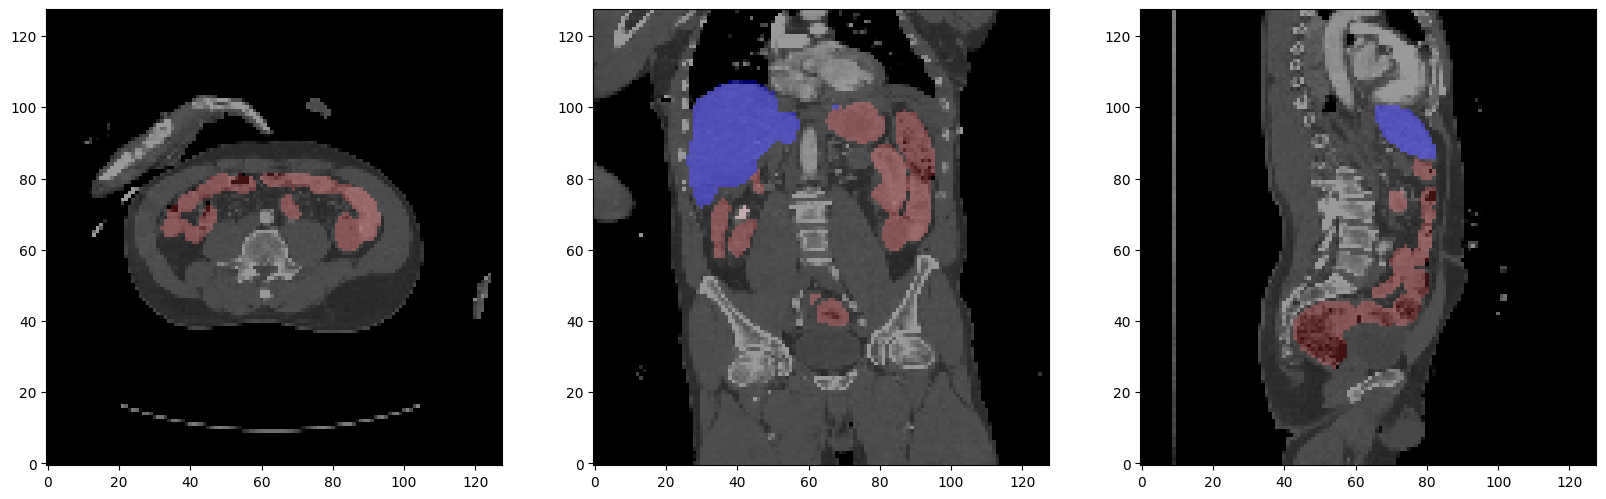

In [9]:
from matplotlib.colors import ListedColormap
#rcParams['figure.figsize'] = 20,8
label_dict = {
    0: 'background',
    1: 'liver',
    2: 'spleen',
    3: 'left kidney',
    4: 'right kidney',
    5: 'bowel'
}

color_dict = {
    0: 'black',
    1: 'blue',
    2: 'green',
    3: 'wheat',
    4: 'pink',
    5: 'brown'
}

cm = ListedColormap(color_dict.values())
def visualize(image,mask=None,title=None,alpha=0.4):
    image=image[:,::-1,:]
    slice1=image.shape[2]//2
    slice2=image.shape[1]//2
    slice3=image.shape[0]//2

    fig,ax=plt.subplots(1,3)
    ax[0].imshow(image[:,:,slice1].T,cmap="gray",origin="lower")
    ax[1].imshow(image[:,slice2,:].T,cmap="gray",origin="lower")
    ax[2].imshow(image[slice3,:,:].T,cmap="gray",origin="lower")
    if mask is not None:
        mask=mask[:,::-1,:]
        ax[0].imshow(mask[:,:,slice1].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
        ax[1].imshow(mask[:,slice2,:].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
        ax[2].imshow(mask[slice3,:,:].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
    fig.suptitle(title)
visualize(image,mask)

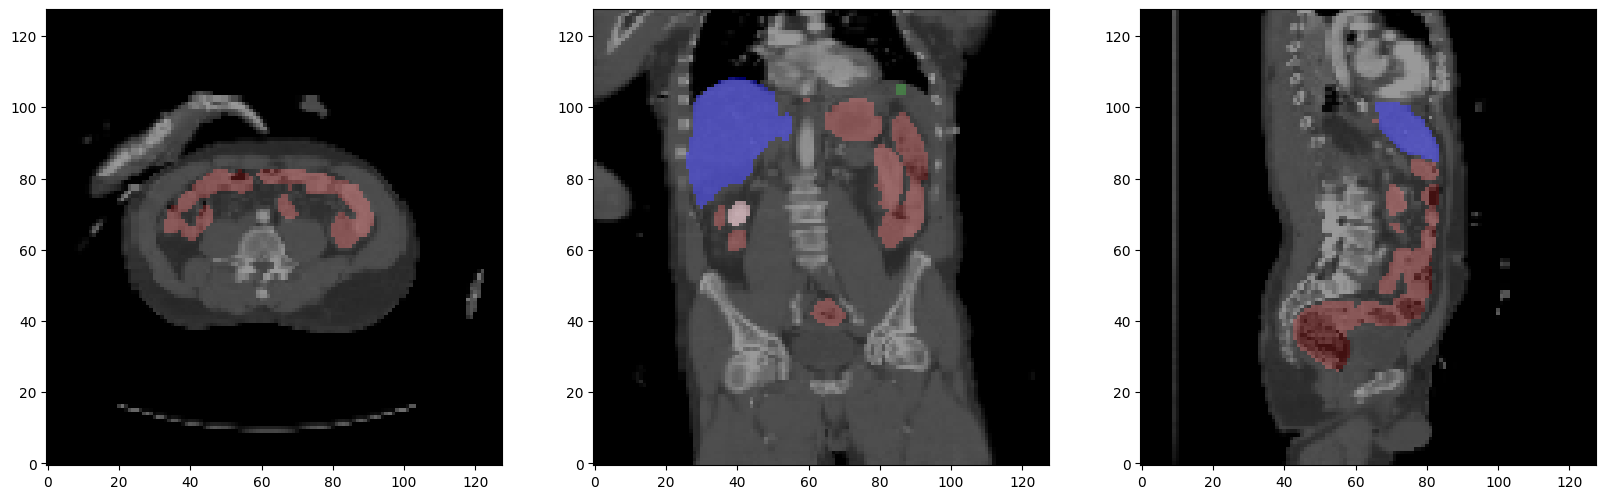

In [10]:
res = transforms_train({'image': np.expand_dims(image, 0).repeat(3, 0), 'mask':mask[None,...]})
im,ma=res["image"],res["mask"]
ma=ma.squeeze().to(torch.int)
im=im[0,...]
im=im.numpy(force=True)
ma=ma.numpy(force=True)
visualize(im,ma)


In [11]:
preprocessed1_dir="preprocessed1"
def preprocess(df,dry_run=False):
    os.makedirs(preprocessed1_dir,exist_ok=True)
    for ind,row in df.iterrows():
        #print(ind,end=" ")
        mask_file=None
        if row.mask_file!="":
            mask_file=row.mask_file
        image_folder=row.image_folder
        print(ind,image_folder,mask_file)
        image,mask=load_image_mask(image_folder,mask_file)
        if not dry_run:
            save_image_file = os.path.join(preprocessed1_dir, f'{row.series_id}.npy')
            np.save(save_image_file,image)
            if mask_file:
                save_mask_file = os.path.join(preprocessed1_dir,f'{row.series_id}_mask.npy')
                np.save(save_mask_file,mask)

PREPROCESS=False
if PREPROCESS:
    preprocess(df)

In [12]:

class SEGDataset(Dataset):
    def __init__(self, df, mode, transform=None,use_preprocessed=True):

        self.df = df
        self.mode = mode
        self.transform = transform
        self.use_preprocessed=use_preprocessed

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        is_test=(self.mode=="test") # in test mode we don't load masks, just predict them
        
        if self.use_preprocessed:
            image_file = os.path.join(preprocessed1_dir, f'{row.series_id}.npy')
            image = np.load(image_file)
            if not is_test:
                mask_file = os.path.join(preprocessed1_dir, f'{row.series_id}_mask.npy')
                mask = np.load(mask_file).astype(np.uint8)
        else:
            image, mask = load_sample(row, has_mask= (not is_test))

        image=torch.from_numpy(image)
        image=image[None,...]
        if not is_test:
            mask=torch.from_numpy(mask)

        if self.transform:
            res = self.transform({'image':image, 'mask':mask[None,...]})   
            image = res['image'] 
            mask = res['mask']
      
        image=image/255.
        if is_test:
            return image
        else:
            mask=mask.squeeze().to(torch.long)
            return image, mask
    


In [13]:


dataset_show = SEGDataset(df_seg, 'train', transform=transforms_train)


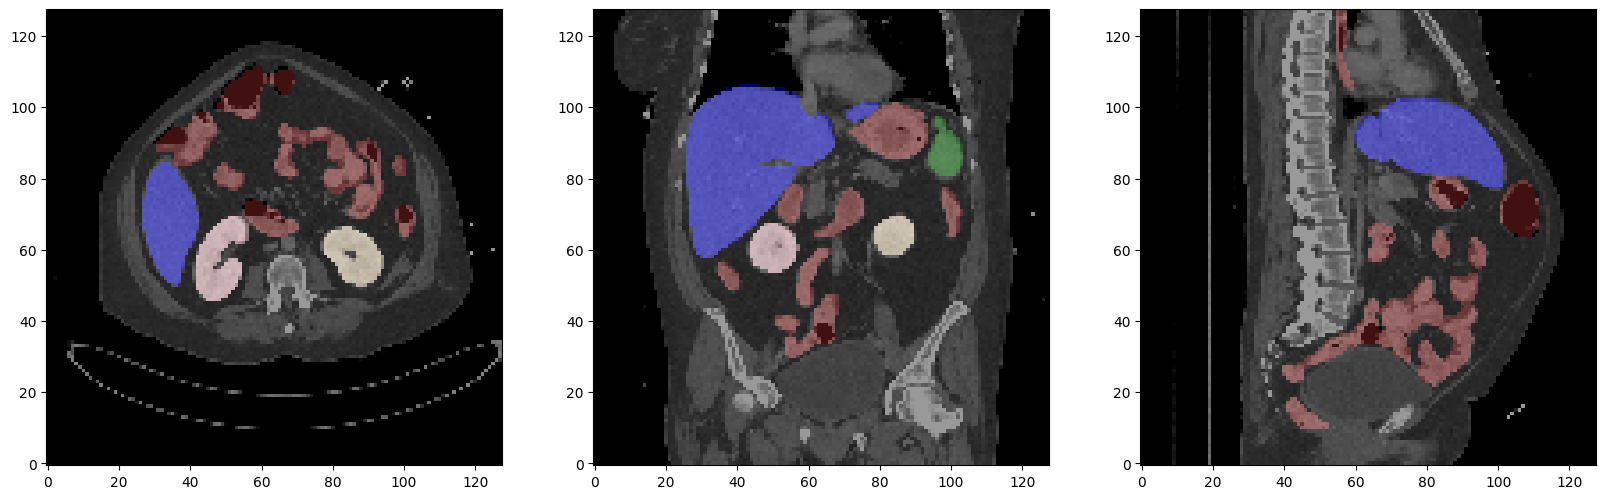

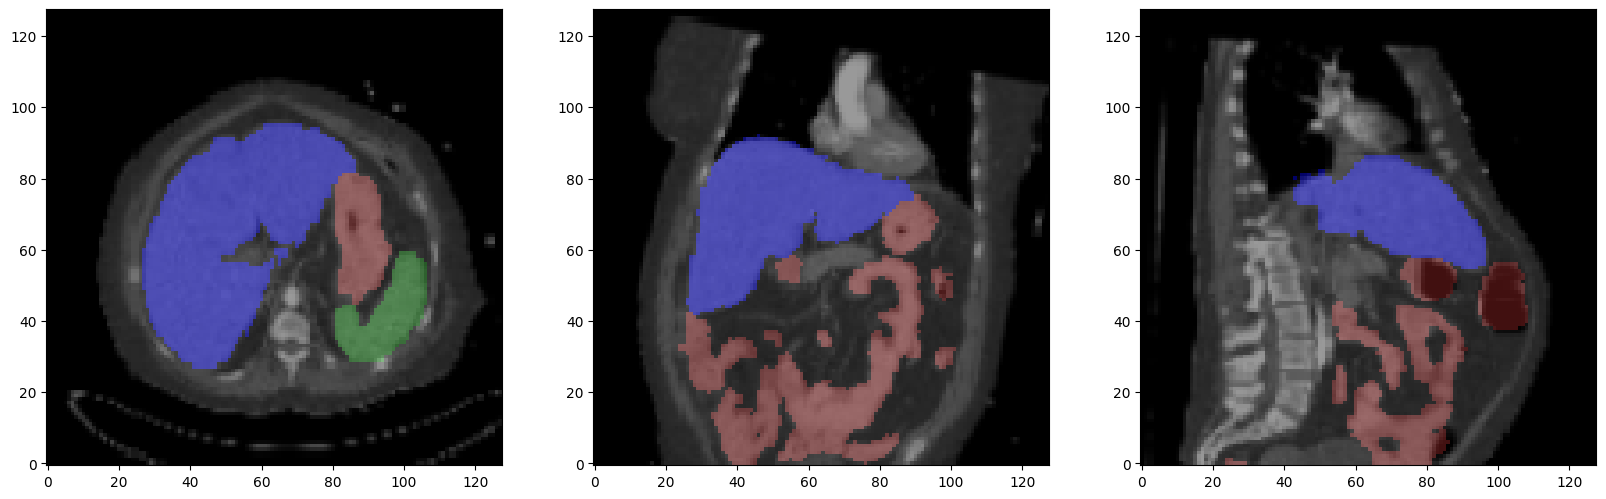

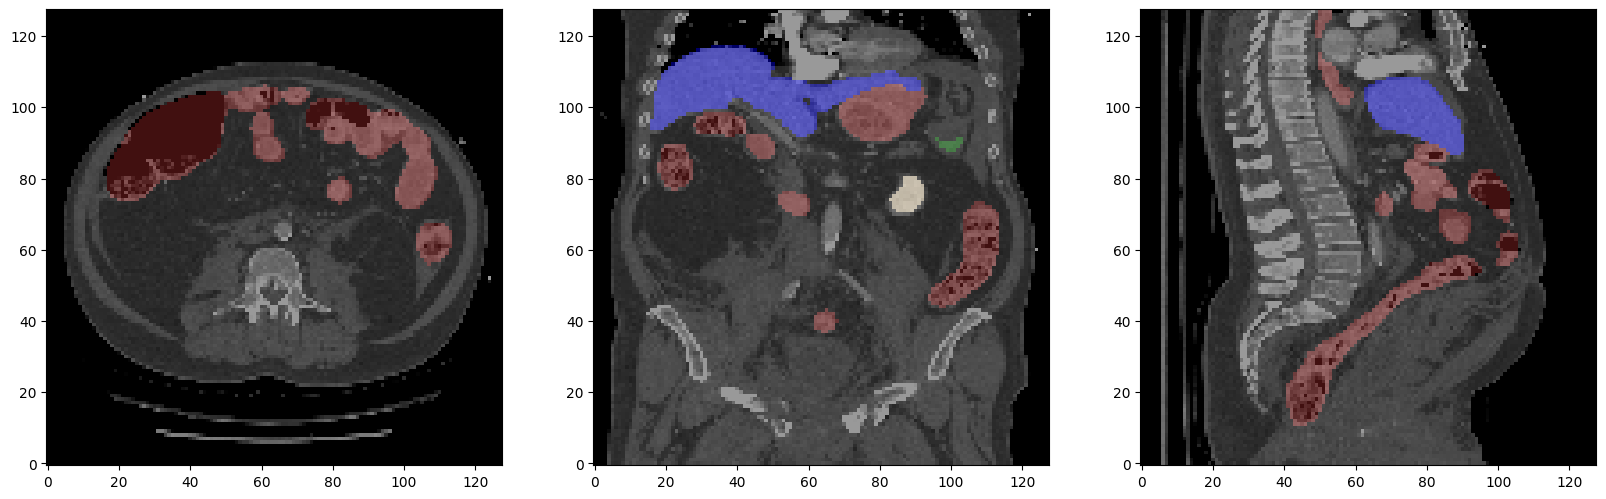

In [14]:
rcParams['figure.figsize'] = 20,8
for i in range(3):
    img, mask = dataset_show[i]
    img=img[0,...]
    img=img.numpy(force=True)
    mask=mask.numpy(force=True)
    visualize(img,mask)

# Model

In [15]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone='resnet18d', segtype='unet', out_dim=6,pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        n_blocks=4
        if segtype == 'unet':
            self.decoder = smp.decoders.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.n_blocks=n_blocks

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:self.n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [16]:
from timm.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m_2d = TimmSegModel()
m = convert_3d(m_2d)
m(torch.rand(1, 1, 128,128,128)).shape

torch.Size([1, 6, 128, 128, 128])

# Loss & Metric

In [17]:

def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    eps: float = 1e-7,
) -> float:
    
    if (torch.sum(y_true)==0) and (torch.sum(y_pred)==0):
        return (torch.sum(y_true)==0).to(torch.float32)
    else:
        intersection = torch.sum(y_pred * y_true)
        cardinality = torch.sum(y_pred) + torch.sum(y_true)
        score = (2.0 * intersection) / (cardinality + eps)
        return score


def multilabel_dice_score(
    y_true: torch.Tensor, # single image, no batch
    y_pred: torch.Tensor,
    eps=1e-7,
    num_classes=6 # including background
):
    ious = []
    for class_index in range(1,num_classes): #ignore background
        y_pred1=(y_pred==class_index).to(torch.float32)
        y_true1=(y_true==class_index).to(torch.float32)
        iou = binary_dice_score(
            y_pred1,
            y_true1,
            eps=eps,
        )
        ious.append(iou)
        
    ious=torch.stack(ious)
    return ious


def dice_loss(input, target,num_classes=6,do_one_hot=True):
    input = torch.nn.Softmax(dim=1)(input)
    smooth = 1.0
    iflat = input.view(-1)
    if do_one_hot:
        t1hot=F.one_hot(target,num_classes)
    else:
        t1hot=target
    tflat = t1hot.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def ce_dice(input, target, loss_weights=loss_weights):
    #loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss1=loss_weights[0]*nn.CrossEntropyLoss()(input,target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = ce_dice

# Train & Valid func

In [18]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        #do_mixup = False
        #if random.random() < p_mixup:
        #    do_mixup = True
        #    images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            #if do_mixup:
            #    loss2 = criterion(logits, gt_masks_sfl)
            #    loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    batch_metrics = [] 
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()
            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for i in range(logits.shape[0]): # iterate over batch
                y_pred=torch.argmax(logits[i],dim=0)
                y_true=gt_masks[i] 
                tmp = multilabel_dice_score(y_pred,y_true)
                batch_metrics.append(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
    batch_metrics=torch.stack(batch_metrics,dim=0)        
    metrics = torch.mean(batch_metrics,axis=0)
    metrics=metrics.numpy(force=True)
    print('dc:', metrics,"mean",np.mean(metrics))

    return np.mean(valid_loss), np.mean(metrics)


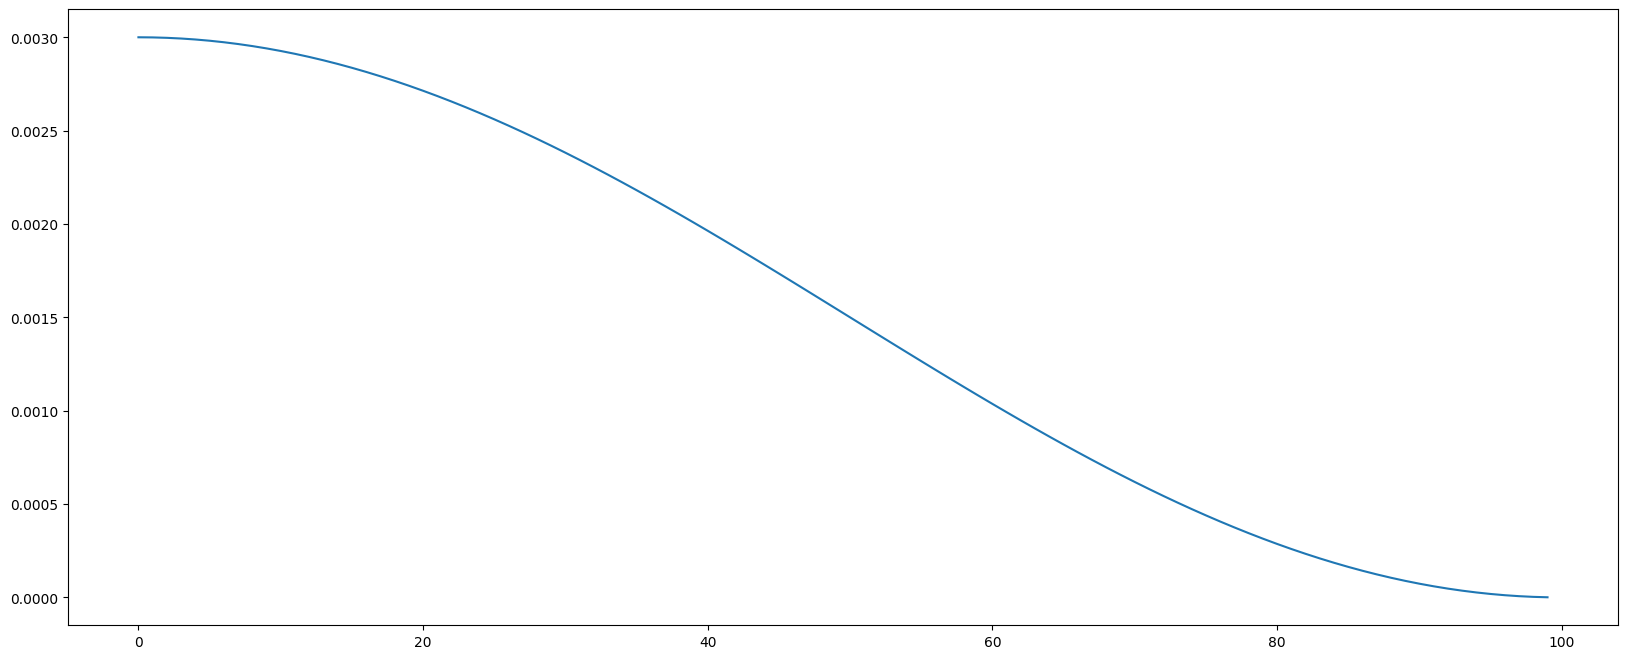

In [19]:

#rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [20]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir_seg, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    metric_best = 0.

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [21]:
TRAIN_STAGE1=False
if TRAIN_STAGE1:
    run(0)
    run(1)
    run(2)
    run(3)
    run(4)

In [22]:
models_seg=[]
for fold in range(5):
    model = TimmSegModel(pretrained=False)
    model = convert_3d(model)
    model = model.to(device)
    load_model_file = os.path.join(model_dir_seg, f'{kernel_type}_fold{fold}_best.pth')
    sd = torch.load(load_model_file)
    if 'model_state_dict' in sd.keys():
        sd = sd['model_state_dict']
    sd = {k[7:] if k.startswith('module.') else k: sd[k] for k in sd.keys()}
    model.load_state_dict(sd, strict=True)
    model.eval()
    models_seg.append(model)

len(models_seg)

5

In [23]:
def infer_masks(df):
    for ind,row in df.iterrows():
        mask_file=None
        if row.mask_file!="":
            continue 
        print(ind,row.series_id)
        
        image1,_=load_image_mask(row.image_folder,None)
        image=(image1/255.).astype(np.float32)
        save_mask_file = os.path.join(preprocessed1_dir,f'{row.series_id}_mask.npy')
        with torch.no_grad():
            image=torch.from_numpy(image).cuda()
            image=image[None,None,...]
            pred_masks = []
            for model in models_seg:
                pmask = model(image).squeeze()
                pmask=nn.Softmax(dim=0)(pmask)
                pred_masks.append(pmask)
        mask = torch.stack(pred_masks, 0).mean(0)
        mask=torch.argmax(mask,dim=0)
        mask=mask.numpy(force=True).astype(np.uint8)
        #visualize(image1,mask)
        np.save(save_mask_file,mask)

PREP_MASKS=False
if PREP_MASKS:
    infer_masks(df)

# Preprocess  Stage 2 crops

In [24]:
#df_p=pd.read_csv(data_dir+"/train.csv")
#df_healthy=df_p[df_p["any_injury"]==0].sample(758)
#df_injured=df_p[(df_p["kidney_healthy"]==0) | (df_p["liver_healthy"]==0)| (df_p["spleen_healthy"]==0) | (df_p["bowel_healthy"]==0)]
#print(len(df_injured),len(df_healthy))
#df1=pd.concat((df_healthy,df_injured))
#df_sample=df.merge(df1,on="patient_id")
#df_sample[["kidney_healthy","liver_healthy","spleen_healthy","bowel_healthy"]].mean()#



In [25]:
import threading
batch_size_seg=1


dataset_seg=SEGDataset(df,mode="valid",use_preprocessed=True)

loader_seg = torch.utils.data.DataLoader(dataset_seg, batch_size=batch_size_seg, shuffle=False, num_workers=num_workers)
mask_size = image_seg_size[2]
n_slice_per_c = [24,24,12,12,128] # liver,spleen,left kidney, right kidney,bowel (all)
n_ch=3

image_size_cls = 296

In [38]:
def load_organ(mask, cid, t_paths, cropped_images,selected_slices):
    n_scans = len(t_paths)
    organ = []
    if cid<4: #liver,spleen,kindey left and right
        mask1 = (mask == (cid+1))
    else:
        mask1=mask # bowel -> extend to all
    

    n_slice=n_slice_per_c[cid]
    dot =check_orient(t_paths)
    if dot<0:
        t_paths=t_paths[::-1]
    
    if np.sum(mask1)>0:
        x = np.where(mask1.sum(1).sum(1)>0)[0]
        y = np.where(mask1.sum(0).sum(1)>0)[0]
        z = np.where(mask1.sum(0).sum(0)>0)[0]
        x1, x2 = max(0, x[0] - 1), min(mask1.shape[0], x[-1] + 1)
        y1, y2 = max(0, y[0] - 1), min(mask1.shape[1], y[-1] + 1)
        z1, z2 = max(0, z[0] - 1), min(mask1.shape[2], z[-1] + 1)

        zz1, zz2 = int(z1 / mask_size * n_scans), int(z2 / mask_size * n_scans) # in original
        inds = np.linspace(zz1 ,zz2-1 ,n_slice).astype(int) # in original
        inds_ = np.linspace(z1 ,z2-1 ,n_slice).astype(int) # in mask

        #select_paths=[t_paths[i] for i in inds]
        #image=load_dicom_3d(select_paths)
        #overlay=cv2.resize(mask[:,:,inds_],(512,512),interpolation=cv2.INTER_NEAREST)
        #print(label_dict[cid+1])
        #visualize(image,overlay)

        selected_slices[cid]=[int(t_paths[i].split('/')[-1].split('.')[0]) for i in inds]
        for (ind, ind_) in zip(inds, inds_):
            mask_this = mask1[:, :, ind_]
            istart=ind-n_ch//2
            iend=istart+n_ch
            istart1=max(istart,0)
            iend1=min(iend,n_scans)
            select_paths=[t_paths[i] for i in range(istart1,iend1)]
         
            image=load_dicom_3d(select_paths) # without resizing 
            if istart<0:
                #print("istart",istart)
                pad=np.zeros((image.shape[0], image.shape[1],-istart),dtype=np.uint8)
                image=np.concatenate((pad,image),axis=2)
            if iend>iend1:
                #print("iend",iend,iend1)
                pad=np.zeros((image.shape[0],image.shape[1],iend-iend1),dtype=np.uint8)
                image=np.concatenate((image,pad),axis=2)
            
            mask_this = mask_this[x1:x2, y1:y2]
            xx1 = int(x1 / mask_size * image.shape[0])
            xx2 = int(x2 / mask_size * image.shape[0])
            yy1 = int(y1 / mask_size * image.shape[1])
            yy2 = int(y2 / mask_size * image.shape[1])
            image = image[xx1:xx2, yy1:yy2]
            image = cv2.resize(image, (image_size_cls, image_size_cls), interpolation = cv2.INTER_LINEAR)
            mask_this = (mask_this * 32).astype(np.uint8)
            mask_this = cv2.resize(mask_this, (image_size_cls, image_size_cls), interpolation = cv2.INTER_NEAREST)
            #print(image.shape,mask_this.shape)
            image = np.concatenate([image, mask_this[:, :, np.newaxis]], -1)
            organ.append(image)
        organ=np.stack(organ,0) #(n_slice, H,W,channel)

    else:
        #print("organ not found",label_dict[cid+1])
        organ=np.zeros((n_slice_per_c[cid],image_size_cls,image_size_cls,n_ch+1))
        selected_slices[cid]=None

    organ= np.transpose(organ,(0,3, 1, 2)) # (n_slice, channels,H,W) 
    VIS=False
    if VIS:
        orgvis=np.transpose(organ,(1,2,3,0))
        vis=orgvis[n_ch//2,...]
        ma=orgvis[-1,...]/255
        visualize(vis,ma,title=label_dict[cid+1]) 

    #organ=organ.float()/255.
    cropped_images[cid]=organ


def load_cropped_images(msk, image_folder):
    threads = [None] * 5
    cropped_images = [None] * 5 
    selected_slices = [None] * 5

    t_paths = sorted(glob(os.path.join(image_folder, "*")), key=lambda x: int(x.split('/')[-1].split(".")[0]))
    for cid in range(5):
        #load_organ(msk,cid,t_paths,cropped_images)
        threads[cid] = threading.Thread(target=load_organ, args=(msk, cid, t_paths, cropped_images,selected_slices))
        threads[cid].start()
    for cid in range(5):
        threads[cid].join()
    cropped_images=np.concatenate(cropped_images,axis=0)    
    return cropped_images, selected_slices


In [39]:

bar = tqdm(loader_seg)
cls_crops_folder="preprocessed2"
bowel_crops_folder="bowel"
df_image=pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
with torch.no_grad():
    for batch_id, (images,masks) in tqdm(enumerate(bar)):
        
        # SEG
        #images = images.cuda()
        #pred_masks = []
        #for model in models_seg:
        #    pmask = model(images)
        #    pmask=nn.Softmax(dim=1)(pmask)
        #    pred_masks.append(pmask)
        #pred_masks = torch.stack(pred_masks, 0).mean(0).cpu().numpy()
        #pred_masks=torch.argmax(pred_masks,dim=0)
        pred_masks=masks.numpy(force=True)

        for i in range(pred_masks.shape[0]):
            ind=batch_id*batch_size_seg+i
            row = df.iloc[ind]
            #print(ind,row.patient_id,row.series_id)
            cropped_images,instance_numbers = load_cropped_images(pred_masks[i,...], row.image_folder)
            nlsk=sum(n_slice_per_c[:4])
            lsk=cropped_images[:nlsk,...]
            bowel=cropped_images[nlsk:,...]
            #print(cropped_images.shape)
            
            #np.savez_compressed(f'{cls_crops_folder}/{row.patient_id}_{row.series_id}',lsk)
            ibowel_injury=df_image[(df_image["patient_id"]==row.patient_id) & (df_image["series_id"]==row.series_id) & (df_image["injury_name"]=="Bowel")]["instance_number"].tolist()
            iextravasation_injury=df_image[(df_image["patient_id"]==row.patient_id) & (df_image["series_id"]==row.series_id) & (df_image["injury_name"]=="Active_Extravasation")]["instance_number"].tolist()
            instance_bowel=np.array(instance_numbers[4]) # 4 -> bowel 
            ibowel=np.isin(instance_bowel,ibowel_injury).astype(np.uint8)
            iextravasation=np.isin(instance_bowel,iextravasation_injury).astype(np.uint8)
            b=np.stack((ibowel,iextravasation),axis=1)
            #if len(ibowel_injury)>0:
            #    print("bowel injury")
            #    print(len(ibowel_injury),np.sum(b))
            #assert not (len(ibowel_injury)>0 and np.sum(b)==0)
            np.savez_compressed(f'{bowel_crops_folder}/{row.patient_id}_{row.series_id}',bowel,b)
            
            gc.collect()



100%|██████████| 4711/4711 [10:41:42<00:00,  8.17s/it]  
4711it [10:41:42,  8.17s/it]
